In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Ideal Penning Trap
Uniform B-field in the z direction, quadratic E field in the radial direction

In [2]:
#### Constants. V0 and d are from the conditions in this paper: https://web2.ph.utexas.edu/~iheds/IntroductionPlasmaPhysics/375%20P%207%20(Penning).pdf
q = 1.6e-19        # Charge (C)
m = 1.67e-27       # Electron mass (kg)
V0 = 10.0          # Voltage (V)
d =  3e-3          # Characteristic trap size (m)
B0 = 1.0           # Magnetic field (T)

In [16]:
#### DifEqs to Solve
def Penning_Eqs(t, state):
    x, y, z, vx, vy, vz = state
    v = [vx, vy, vz]
    B = [0,0,B0]

    # Radial E field (x and y only)
    E_xy = (V0 / (2 * d**2)) * np.array([x, y])

    # Cross product for Lorentz Force
    cross = np.cross(v, B)

    # Acceleration in x and y from both E and B
    ax = (q / m) * (E_xy[0] + cross[0])
    ay = (q / m) * (E_xy[1] + cross[1])

    # z is SHO
    az = -q * V0 / (m * d**2) * z

    return [vx, vy, vz, ax, ay, az]

In [17]:
#### Initial Conditions
r0 = [1e-4, 0, 1e-4]    # Initial position (x, y, z)
v0 = [0, 1000, 100]     # Initial velocity (vx, vy, vz)
initial_state = r0 + v0

#### Time Setup
t0 = 0
tf = 1e-4
t = np.linspace(t0, tf, 100000)

#### Solve Dif Eqs
solution = solve_ivp(Penning_Eqs, [t0,tf], initial_state, t_eval=t, method='RK45')
x, y, z = solution.y[0], solution.y[1], solution.y[2]
vx, vy, vz = solution.y[3], solution.y[4], solution.y[5]


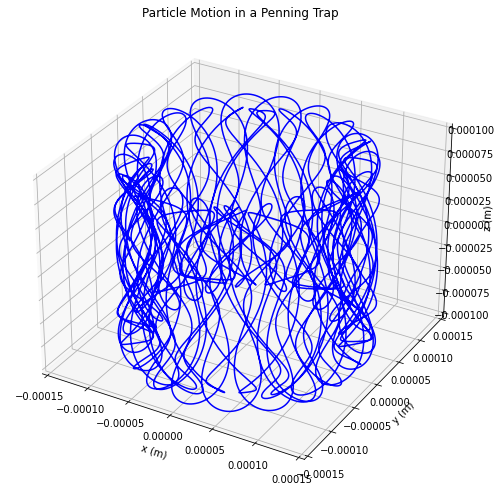

In [18]:
# Plot in 3d first
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

### If we plot all indices, the plot is completely unreadable
# ax.plot3D(x,y,z, color='blue')


ax.plot3D(x[:10000], y[:10000], z[:10000], color='blue')
ax.set_title("Particle Motion in a Penning Trap")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")

# Can change axis of viewing to see oscillations better
# ax.view_init(elev=0,azim=0)

plt.tight_layout()
plt.show()

In [21]:
print(min(z))

-0.0001000414767863239


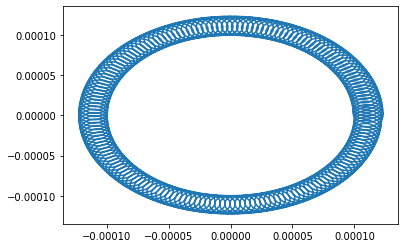

In [6]:
# Visualize both radial oscillations
plt.plot(x[:11250],y[:11250])


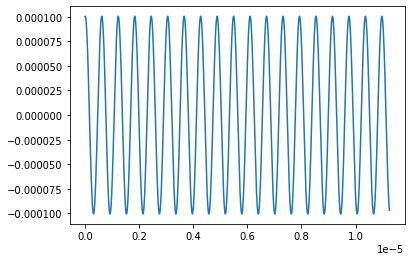

In [7]:
# Visualize the oscillation up and down the trap
plt.plot(t[:11250],z[:11250])

## ALPHA Traps
ALPHA traps consist of superimposed Penning-Malmberg traps with an Ioffe Pritchard trap.

An Ioffe Pritchard trap has a magnetic field $$\bold{B} = [B_0 + \frac{1}{2}B''z^2 - \frac{1}{4}B''(x^2+y^2)]\hat{z} + (B'-\frac{1}{2}B''z)x\hat{x}+(-B'-\frac{1}{2}B''z)y\hat{y}$$ 

The Penning-Malmberg trap has an electric field in both the radial and z components.

Some issues with this code so far is that if we were to assume the particle was neutral, the particle is not trapped by the magnetic potential.  ALPHA says the magnetic dipole moment of a neutral particle is how the Ioffe-Pritchard traps the particle, so we will have to account for this dipole moment somehow.  Additionally, the Ioffe-Pritchard trap magnetic field comes from 8 wires.  We haven't used the Biot-Savant Law to explictly calculate these values.  Instead, $B''$ and $B'$ values were our best guesses that made a particle stay contained in the trap.

In [25]:

#### Physical constants
q = 1.6e-19         # charge (C)
m = 1.67e-27        # mass (kg), approx proton
omega_z = 2e5       # axial angular frequency (rad/s)
V0 = 10
d = 1e-3
mu_0 = 4 * np.pi * 1e-7  # T·m/A


#### Magnetic field parameters
B0 = 1.0            # T, base field along z
Bp = 1e3            # T/m, radial gradient
Bpp = 1e4           # T/m^2, axial curvature


#### Electric field from Penning-Malmberg trap
def electric_field(x, y, z):
    Ex = (V0 / (2 * d**2)) * x
    Ey = (V0 / (2 * d**2)) * y
    Ez = -(V0 / d**2) * z
    return np.array([Ex, Ey, Ez])

#### Ioffe-Pritchard magnetic field
def magnetic_field(x, y, z):
    Bx = (Bp -.5*Bpp*z)* x
    By = (-Bp -.5*Bpp*z) * y
    Bz = B0 + 0.5 * Bpp * z**2 - .25*Bpp*(x**2+y**2)
    return np.array([Bx, By, Bz])

#### Equations of motion
def equations(t, state):
    x, y, z, vx, vy, vz = state
    v = np.array([vx, vy, vz])
    E = electric_field(x, y, z)
    B = magnetic_field(x, y, z)
    a = (q / m) * (E + np.cross(v, B))

    return [vx, vy, vz, *a]

#### Initial conditions
r0 = [1e-4, 0, 1e-4]    # Initial position (x, y, z)
v0 = [0, 1000, 100]     # Initial velocity (vx, vy, vz)
initial_state = r0 + v0

#### Time setup
t_span = (0, 1e-4)
t_eval = np.linspace(*t_span, 500000)

#### Solve ODE 
sol = solve_ivp(equations, t_span, initial_state, t_eval=t_eval)

#### Extract results
x, y, z = sol.y[0], sol.y[1], sol.y[2]
vx, vy, vz = sol.y[3], sol.y[4], sol.y[5]
t = sol.t


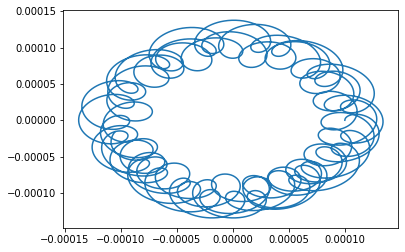

In [26]:
plt.plot(x[:20000],y[:20000])

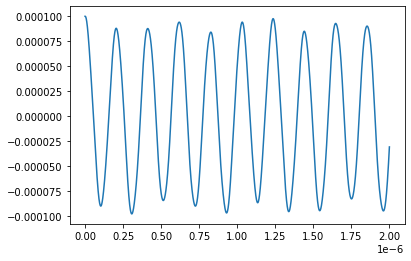

In [27]:
plt.plot(t[:10000],z[:10000])

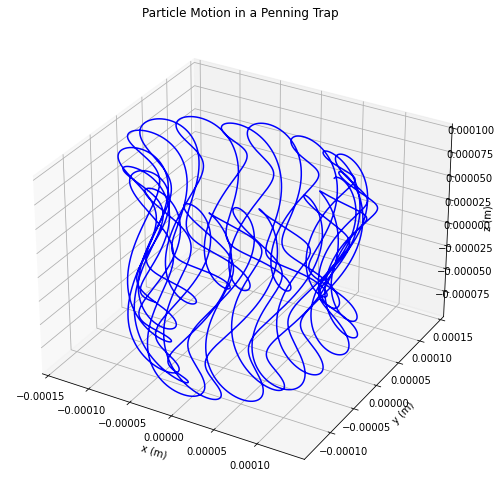

In [32]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(x[:20000],y[:20000],z[:20000], color='blue')
ax.set_title("Particle Motion in a Penning Trap")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")

# Can change axis of viewing to see oscillations better
# ax.view_init(elev=0,azim=0)

plt.tight_layout()
plt.show()

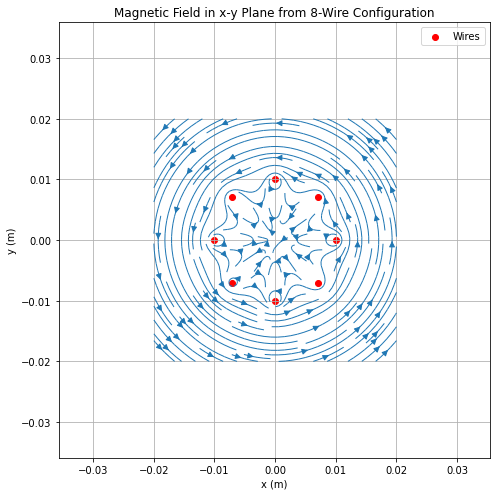

In [ ]:
# Magnetic Field from 8-Wire Configuration in ALPHA Trap
import numpy as np
import matplotlib.pyplot as plt

# Physical constant
mu_0 = 4 * np.pi * 1e-7  # T·m/A

# Parameters
I = 100  # Current in each wire (A)
N_wires = 8
radius = 0.01  # Radius of wire circle (m)
grid_size = 100  # Resolution of the grid
field_extent = 0.02  # Half-width of grid (m)

# Wire positions (evenly spaced on a circle in x-y plane)
theta = np.linspace(0, 2 * np.pi, N_wires, endpoint=False)
wire_positions = np.stack((radius * np.cos(theta), radius * np.sin(theta)), axis=1)

# Grid in x-y plane
x = np.linspace(-field_extent, field_extent, grid_size)
y = np.linspace(-field_extent, field_extent, grid_size)
X, Y = np.meshgrid(x, y)

# Initialize field arrays
Bx = np.zeros_like(X)
By = np.zeros_like(Y)

# Compute Biot–Savart contribution from each wire
for x0, y0 in wire_positions:
    dx = X - x0
    dy = Y - y0
    r_squared = dx**2 + dy**2
    r_squared[r_squared == 0] = np.nan  # Avoid division by zero

    r = np.sqrt(r_squared)
    B_magnitude = mu_0 * I / (2 * np.pi * r)

    # Direction: azimuthal (tangent to the circle around each wire)
    Bx += -B_magnitude * dy / r
    By +=  B_magnitude * dx / r

# Plot vector field
plt.figure(figsize=(7, 7))
plt.streamplot(x, y, Bx, By, density=1.2, linewidth=1, arrowsize=1.2)
plt.scatter(wire_positions[:, 0], wire_positions[:, 1], color='red', label='Wires')
plt.title("Magnetic Field in x-y Plane from 8-Wire Configuration")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:

#### Physical constants
q = 1.6e-19         # charge (C)
m = 1.67e-27        # mass (kg), approx proton
omega_z = 2e5       # axial angular frequency (rad/s)
V0 = 10
d = 1e-3
mu_0 = 4 * np.pi * 1e-7  # T·m/A



#### Magnetic field parameters
B0 = 1.0            # T, base field along z
Bp = 1e3            # T/m, radial gradient
Bpp = 1e4           # T/m^2, axial curvature
I = 100  # Current in each wire (A)
N_wires = 8
radius = 0.01  # Radius of wire circle (m)
field_extent = 0.02  # Half-width of grid (m)

Bx = 0
By = 0

# Wire positions (evenly spaced on a circle in x-y plane)
theta = np.linspace(0, 2 * np.pi, N_wires, endpoint=False)
wire_positions = np.stack((radius * np.cos(theta), radius * np.sin(theta)), axis=1)
x = np.linspace(-field_extent, field_extent, 100)
y = np.linspace(-field_extent, field_extent, 100)
X, Y = np.meshgrid(x, y)

for x0, y0 in wire_positions:
    dx = X - x0
    dy = Y - y0
    r_squared = dx**2 + dy**2
    r_squared[r_squared == 0] = np.nan  # Avoid division by zero

    r = np.sqrt(r_squared)
    B_magnitude = mu_0 * I / (2 * np.pi * r)

    # Direction: azimuthal (tangent to the circle around each wire)
    Bx += -B_magnitude * dy / r
    By +=  B_magnitude * dx / r

print(Bx)

E_x = 0
E_y = 0
z = np.linspace(-0.0001, 0.0001, 100)
for x0, y0 in wire_positions:
    dx = X - x0
    dy = Y - y0
    r_squared = dx**2 + dy**2
    r_squared[r_squared == 0] = np.nan  # Avoid division by zero

    r = np.sqrt(r_squared)
    E_mag = (V0 / (2 * d**2))

    # Direction: azimuthal (tangent to the circle around each wire)
    E_x += -E_mag * dy
    E_y +=  E_mag * dx

B = [Bx, By, 0]
E = [E_x, E_y, 0]

#### Equations of motion
def equations(t, state):
    x, y, z, vx, vy, vz = state
    v = np.array([vx, vy, vz])
    a = (q / m) * (E + np.cross(v, B))

    return [vx, vy, vz, *a]

#### Initial conditions
r0 = [1e-4, 0, 1e-4]    # Initial position (x, y, z)
v0 = [0, 1000, 100]     # Initial velocity (vx, vy, vz)
initial_state = r0 + v0

#### Time setup
t_span = (0, 1e-4)
t_eval = np.linspace(*t_span, 500000)

#### Solve ODE 
sol = solve_ivp(equations, t_span, initial_state, t_eval=t_eval)

#### Extract results
x, y, z = sol.y[0], sol.y[1], sol.y[2]
vx, vy, vz = sol.y[3], sol.y[4], sol.y[5]
t = sol.t


[[ 0.00400098  0.00408279  0.00416625 ...  0.00416625  0.00408279
   0.00400098]
 [ 0.00400013  0.00408365  0.00416892 ...  0.00416892  0.00408365
   0.00400013]
 [ 0.00399754  0.00408275  0.00416984 ...  0.00416984  0.00408275
   0.00399754]
 ...
 [-0.00399754 -0.00408275 -0.00416984 ... -0.00416984 -0.00408275
  -0.00399754]
 [-0.00400013 -0.00408365 -0.00416892 ... -0.00416892 -0.00408365
  -0.00400013]
 [-0.00400098 -0.00408279 -0.00416625 ... -0.00416625 -0.00408279
  -0.00400098]]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.